<a href="https://colab.research.google.com/github/omsin/NeoCP/blob/main/NeoCP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

Build a model to automatically predict tags for a given a __StackExchange__ question by using the text of the question.

__Dataset Specs__: Over 85,000 questions

[Download Link](https://www.kaggle.com/stackoverflow/statsquestions#Questions.csv)

[Introduction to Pytorch Lightning](https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09)

In [3]:
! nvidia-smi

Sun Apr 17 09:58:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
! pip install kaggle
! pip install --upgrade kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json /content
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download stackoverflow/statsquestions
! unzip statsquestions.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 154M/158M [00:02<00:00, 49.4MB/s]
100% 158M/158M [00:02<00:00, 57.6MB/s]
Archive:  statsquestions.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                
  inflating: database.sqlite         


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Steps to Follow



1. Install & Import Libraries
2. Load the Data and Pre-process it
3. Prepare Dataset & Datamodule
4. Define the BERT Model for Fine-tuning
5. Train the Model
6. Evaluate Model Performance
7. Inference



## Install and Import Libraries

In [4]:
! pip install -q pytorch-lightning

     |████████████████████████████████| 582 kB 14.4 MB/s 
     |████████████████████████████████| 136 kB 101.9 MB/s 
     |████████████████████████████████| 596 kB 91.2 MB/s 
     |████████████████████████████████| 408 kB 101.1 MB/s 
     |████████████████████████████████| 1.1 MB 78.7 MB/s 
     |████████████████████████████████| 271 kB 95.3 MB/s 
     |████████████████████████████████| 144 kB 93.1 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 


In [7]:
! pip install -q bs4
! pip install -q transformers

     |████████████████████████████████| 4.0 MB 14.9 MB/s 
     |████████████████████████████████| 895 kB 83.2 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 6.6 MB 84.3 MB/s 


In [8]:
# Import all libraries
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Load Dataset

In [10]:
# load the stackoverflow questions dataset
df_questions = pd.read_csv('/content/Questions.csv',encoding='latin-1')

# load the tags dataset
df_tags = pd.read_csv('/content/Tags.csv')

In [11]:
#print first 5 rows
df_questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=..."
1,21,59.0,2010-07-19T19:24:36Z,4,Forecasting demographic census,<p>What are some of the ways to forecast demog...
2,22,66.0,2010-07-19T19:25:39Z,208,Bayesian and frequentist reasoning in plain En...,<p>How would you describe in plain English the...
3,31,13.0,2010-07-19T19:28:44Z,138,What is the meaning of p values and t values i...,<p>After taking a statistics course and then t...
4,36,8.0,2010-07-19T19:31:47Z,58,Examples for teaching: Correlation does not me...,"<p>There is an old saying: ""Correlation does n..."


In [12]:
df_tags.head()

,Id,Tag
0,1,bayesian
1,1,prior
2,1,elicitation
3,2,distributions
4,2,normality


## Pre-process the data

The Body column contains data in a HTML format and thus we need to strip off the HTML also we will do a lower case conversion to reduce vocabulary size

In [13]:
def pre_process(text):

  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [14]:
# clean the text in Body column
df_questions['Clean_Body'] = df_questions['Body'].apply(pre_process)

In [15]:
df_questions['Body'][1]

"<p>What are some of the ways to forecast demographic census with some validation and calibration techniques?</p>\n\n<p>Some of the concerns:</p>\n\n<ul>\n<li>Census blocks vary in sizes as rural\nareas are a lot larger than condensed\nurban areas. Is there a need to account for the area size difference?</li>\n<li>if let's say I have census data\ndating back to 4 - 5 census periods,\nhow far can i forecast it into the\nfuture?</li>\n<li>if some of the census zone change\nlightly in boundaries, how can i\naccount for that change?</li>\n<li>What are the methods to validate\ncensus forecasts? for example, if i\nhave data for existing 5 census\nperiods, should I model the first 3\nand test it on the latter two? or is\nthere another way?</li>\n<li>what's the state of practice in\nforecasting census data, and what are\nsome of the state of the art methods?</li>\n</ul>\n"

In [16]:
df_questions['Clean_Body'][1]

'what are some of the ways to forecast demographic census with some validation and calibration techniques some of the concerns census blocks vary in sizes as rural areas are a lot larger than condensed urban areas is there a need to account for the area size difference if let s say i have census data dating back to census periods how far can i forecast it into the future if some of the census zone change lightly in boundaries how can i account for that change what are the methods to validate census forecasts for example if i have data for existing census periods should i model the first and test it on the latter two or is there another way what s the state of practice in forecasting census data and what are some of the state of the art methods'

Merge the 'questions' and 'tags' dataframe on the id column to create a single dataframe.

In [17]:
# count of unique tags
len(df_tags['Tag'].unique())

1315

In [18]:
df_tags['Tag'].value_counts()

r                       13236
regression              10959
machine-learning         6089
time-series              5559
probability              4217
                        ...  
fmincon                     1
doc2vec                     1
sympy                       1
adversarial-boosting        1
corpus-linguistics          1
Name: Tag, Length: 1315, dtype: int64

In [19]:
# remove "-" from the tags
df_tags['Tag']= df_tags['Tag'].apply(lambda x:re.sub("-"," ",x))

In [20]:
# Consider only Top 10 tags - want to keep a smaller dataset
top_tags = df_tags['Tag'].value_counts().keys()[0:10]
top_tags

Index(['r', 'regression', 'machine learning', 'time series', 'probability',
       'hypothesis testing', 'self study', 'distributions', 'logistic',
       'classification'],
      dtype='object')

In [21]:
# First group tags Id wise
df_tags = df_tags.groupby('Id').apply(lambda x:x['Tag'].values).reset_index(name='tags')
df_tags.head()

,Id,tags
0,1,"[bayesian, prior, elicitation]"
1,2,"[distributions, normality]"
2,3,"[software, open source]"
3,4,"[distributions, statistical significance]"
4,6,[machine learning]


In [22]:
# merge tags and questions datasets
df = pd.merge(df_questions,df_tags,how='inner',on='Id')

In [23]:
# Retain only the columns we will use for training the model - Tags will be the label
df = df[['Clean_Body','tags']]
df.head()

,Clean_Body,tags
0,last year i read a blog post from brendan o co...,[machine learning]
1,what are some of the ways to forecast demograp...,"[forecasting, population, census]"
2,how would you describe in plain english the ch...,"[bayesian, frequentist]"
3,after taking a statistics course and then tryi...,"[hypothesis testing, t test, p value, interpre..."
4,there is an old saying correlation does not me...,"[correlation, teaching]"


In [24]:
df.shape

(85085, 2)

In [25]:
#df.to_csv("clean_question_tag.csv")

Since we are limiting only to the top 10 tags in the label - only retain questions(Body column) that have association with these tags.

In [26]:
# Filter out records ( values in clean_body and tags) that have atleast one of the top tags

x=[] # To store the filtered clean_body values
y=[] # to store the corresponding tags
# Convert to list data type
lst_top_tags = list(top_tags)

for i in range(len(df['tags'])):
    temp=[]
    for tag in df['tags'][i]:
        if tag in lst_top_tags:
            temp.append(tag)

    if(len(temp)>0):
        x.append(df['Clean_Body'][i])
        y.append(temp)

In [27]:
# number of records that will be used for training and testing
len(x)

44928

In [28]:
# Encode the tags(labels) in a binary format in order to be used for training

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
yt = mlb.fit_transform(y)
yt.shape

(44928, 10)

In [29]:
# Getting a sense of how the tags data looks like
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

[0 0 0 0 1 0 0 0 0 0]
[('machine learning',)]
['classification' 'distributions' 'hypothesis testing' 'logistic'
 'machine learning' 'probability' 'r' 'regression' 'self study'
 'time series']


View the distribution of word count/question to decide the max length for Text that will be used for modelling

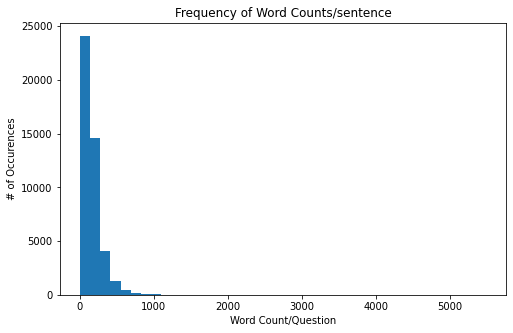

In [34]:
# compute no. of words in each question
questions = x
word_cnt = [len(quest.split()) for quest in questions]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlabel('Word Count/Question')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()

Generally looks like we should be good with a max word count = 300 since that should cover the text of most questions. Getting a sense of how many questions have more that 300 words.

## Split the dataset into training ,validation and test set. 

In [ ]:
from sklearn.model_selection import train_test_split
# First Split for Train and Test
x_train,x_test,y_train,y_test = train_test_split(x, yt, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)
# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [ ]:
len(x_tr) ,len(x_val), len(x_test)

(32348, 8087, 4493)

## Preparing the Dataset and DataModule

First create  QTagDataset class based on the Dataset class,that readies the text in a format needed for the BERT Model

In [ ]:
class QTagDataset (Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }
        

Since we are using Pytorch Lightning for Model training - we will setup the QTagDataModule class that is derived from the LightningDataModule 

In [ ]:
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=2)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16)

In [ ]:
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "bert-base-cased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
max_word_cnt = 300
quest_cnt = 0

# For every sentence...
for question in questions:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(question, add_special_tokens=True)

    # Update the maximum sentence length.
    if len(input_ids) > max_word_cnt:
        quest_cnt +=1

print(f'# Question having word count > {max_word_cnt}: is  {quest_cnt}')

Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors


# Question having word count > 300: is  7205


In [ ]:
# Initialize the parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 32
MAX_LEN = 300
LR = 2e-05

In [ ]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

## Train the Model

Setup the Multi-label Classifier Model - dervived from LightningModule , similar to nn.module of PyTorch

In [ ]:
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=10, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]
    

In [ ]:
# Instantiate the classifier model
steps_per_epoch = len(x_tr)//BATCH_SIZE
model = QTagClassifier(n_classes=10, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [ ]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS , gpus = 1, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 30)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
#torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
# ใส่ # เพิ่มใน file: pytorch_lightning/trainer/trainer.py        
# if self.datamodule is not None:
#     self.datamodule.setup(stage=fn)

In [ ]:
# Train the Classifier Model
trainer.fit(model, QTdata_module)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 108 M 
1 | classifier | Linear            | 7.7 K 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.272   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# Evaluate the model performance on the test dataset
trainer.test(model,datamodule=QTdata_module)

In [ ]:
# Visualize the logs using tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Evaluate Model Performance on Test Set

In [ ]:
# Retreive the checkpoint path for best model
model_path = checkpoint_callback.best_model_path
model_path

In [ ]:
len(y_test), len(x_test)

In [ ]:
# Size of Test set
print(f'Number of Questions = {len(x_test)}')

### setup test dataset for BERT

In [ ]:
from torch.utils.data import TensorDataset

# Tokenize all questions in x_test
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  Bert_tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_quest['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_quest['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 64  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)
    

In [ ]:
#pred_data[0]

In [ ]:
#len(pred_dataloader.dataset)

### Prediction on test set

In [ ]:
flat_pred_outs = 0
flat_true_labels = 0

In [ ]:
# Put model in evaluation mode
model = model.to(device) # moving model to cuda
model.eval()

# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #i+=1
        # Store predictions and true labels
        #print(i)
        #print(outputs)
        #print(logits)
        #print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)


In [ ]:
pred_outs[0][0]

In [ ]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
flat_pred_outs.shape , flat_true_labels.shape

### Predictions of Tags in Test set

The predictions are in terms of logits (probabilities for each of the 16 tags). Hence we need to have a threshold value to convert these probabilities to 0 or 1.

Let's specify a set of candidate threshold values. We will select the threshold value that performs the best for the test set.

In [ ]:
#define candidate threshold values
threshold  = np.arange(0.4,0.51,0.01)
threshold

Let's define a function that takes a threshold value and uses it to convert probabilities into 1 or 0.

In [ ]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred

In [ ]:
flat_pred_outs[3]

In [ ]:
flat_true_labels[3]

In [ ]:
flat_pred_outs[10]

In [ ]:
flat_true_labels[10]

In [ ]:
from sklearn import metrics
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = flat_true_labels.ravel() 

for thresh in threshold:
    
    #classes for each threshold
    pred_bin_label = classify(flat_pred_outs,thresh) 

    #convert to 1D array
    y_pred = np.array(pred_bin_label).ravel()

    scores.append(metrics.f1_score(y_true,y_pred))

In [ ]:
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')

In [ ]:
#y_true = flat_true_labels.ravel() 

In [ ]:
#y_true

In [ ]:
#flat_true_labels

### Performance Score Evaluation

In [ ]:
#predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,opt_thresh)
y_pred = np.array(y_pred_labels).ravel() # Flatten

In [ ]:
print(metrics.classification_report(y_true,y_pred))

In [ ]:
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)

df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

In [ ]:
df.sample(10)

In [ ]:
#flat_true_labels.shape

In [ ]:
#np.array(y_pred_labels).shape

In [ ]:
#y_temp = mlb.inverse_transform(flat_true_labels)
#y_temp

# Inference

In [ ]:
# load a model along with its weights, biases and hyperparameters
QTmodel = QTagClassifier.load_from_checkpoint(model_path)
QTmodel.eval()

In [ ]:
#Function to Predict Tags from a Question
def predict(question):
    text_enc = Bert_tokenizer.encode_plus(
            question,
            None,
            add_special_tokens=True,
            max_length= MAX_LEN,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'      
    )
    outputs = QTmodel(text_enc['input_ids'], text_enc['attention_mask'])
    pred_out = outputs[0].detach().numpy()
    #print(f'Outputs = {outputs}')
    #print(f'Type = {type(outputs)}')
    #print(f'Pred Outputs = {pred_out}')
    #print(f'Type = {type(pred_out)}')
    #preds = np.round(pred_out)
    preds = [(pred > opt_thresh) for pred in pred_out ]
    #pred_list = [ round(pred) for pred in pred_logits ]
    preds = np.asarray(preds)
    #print(f'Predictions = {preds}')
    #print(f'Type = {type(preds)}')
    #print(mlb.classes_)
    new_preds = preds.reshape(1,-1).astype(int)
    #print(new_preds)
    pred_tags = mlb.inverse_transform(new_preds)
    #print(mlb.inverse_transform(np.array(new_preds)))
    return pred_tags 
    

### Try out the Model - Ask a question

In [ ]:
# Your question stored in the question variable
question = "based on the following relationship between matthew s correlation coefficient mcc and chi square mcc is the pearson product moment correlation coefficient is it possible to conclude that by having imbalanced binary classification problem n and p df following mcc is significant mcc sqrt which is mcc when comparing two algorithms a b with trials of times if mean mcc a mcc a mean mcc b mcc b then a significantly outperforms b thanks in advance edit roc curves provide an overly optimistic view of the performance for imbalanced binary classification regarding threshold i m not a big fan of not using it as finally one have to decide for a threshold and quite frankly that person has no more information than me to decide upon hence providing pr or roc curves are just for the sake of circumventing the problem for publishing"

# Call the predict function to predict the associated Tags
tags = predict(question)
if not tags[0]:
    print('This Question can not be associated with any known tag - Please review to see if a new tag is required ')
else:
    print(f'Following Tags are associated : \n {tags}')